# **MNIST dataset**

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np



# Parameters
batch_size = 32
learning_rate = 0.001
num_epochs = 5
num_classes = 10


transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert MNIST grayscale to 3 channels
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Reduce dataset size
train_subset = Subset(train_dataset, np.arange(5000))
test_subset = Subset(test_dataset, np.arange(1000))

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)


def modify_model(model, num_classes):
    if hasattr(model, 'fc'):
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif hasattr(model, 'classifier'):
        if isinstance(model.classifier, nn.Sequential):
            num_ftrs = model.classifier[-1].in_features
            model.classifier[-1] = nn.Linear(num_ftrs, num_classes)
        else:
            num_ftrs = model.classifier.in_features
            model.classifier = nn.Linear(num_ftrs, num_classes)
    return model

Using device: cuda


# **Use subset of the dataset (MNIST) to reduce runtime**

In [6]:
models_to_train = {
    "ResNet18": models.resnet18(pretrained=True),
    "VGG16": models.vgg16(pretrained=True),
    "MobileNetV2": models.mobilenet_v2(pretrained=True)
}

results = {}
criterion = nn.CrossEntropyLoss()

for model_name, model in models_to_train.items():
    print(f"\nTraining {model_name}...")
    model = modify_model(model, num_classes).to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)  # No mixed precision
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    results[model_name] = accuracy
    print(f"Test Accuracy of {model_name}: {accuracy:.2f}%")



Training ResNet18...
Epoch [1/5], Loss: 0.2047
Epoch [2/5], Loss: 0.0881
Epoch [3/5], Loss: 0.0661
Epoch [4/5], Loss: 0.0453
Epoch [5/5], Loss: 0.0323
Test Accuracy of ResNet18: 97.90%

Training VGG16...
Epoch [1/5], Loss: 1.4608
Epoch [2/5], Loss: 0.4022
Epoch [3/5], Loss: 0.4661
Epoch [4/5], Loss: 0.2025
Epoch [5/5], Loss: 0.1635
Test Accuracy of VGG16: 91.50%

Training MobileNetV2...
Epoch [1/5], Loss: 0.2241
Epoch [2/5], Loss: 0.0956
Epoch [3/5], Loss: 0.0783
Epoch [4/5], Loss: 0.0736
Epoch [5/5], Loss: 0.0523
Test Accuracy of MobileNetV2: 98.00%


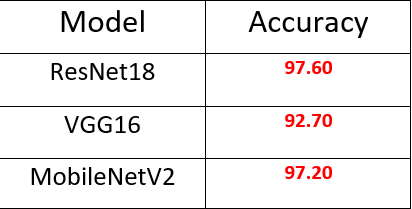